In [2]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
from torch import nn
import seaborn as sn

# Subject Presentation

This project involves detecting anomalies in ECG readings. To do this, we have a set of 5000 ECGs, extracted from the “https://www.timeseriesclassification.com/description.php?Dataset=ECG5000” website.  
Usually, a signal from an ECG can be represented as below (figure extracted from https://a-fib.com/treatments-for-atrial-fibrillation/diagnostic-tests-2/the-ekg-signal/):

(-0.5, 439.5, 455.5, -0.5)

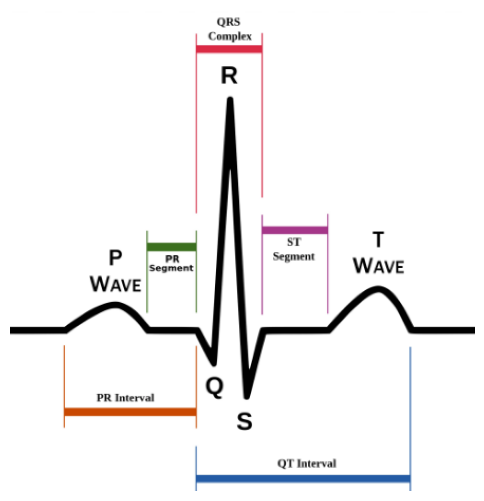

In [72]:
plt.figure(figsize=(6,10))
plt.imshow(plt.imread('ecg_signal.png'))
plt.axis('off')

The dataset include normal ECGs, and the following conditions:  
- R-on-T Premature Ventricular Contraction (RoT PVC), which can be interpreted as a superposition of the R wave on the T wave.  
- Premature Ventricular Contraction (PVC), which can be deduced from an absence of P wave, and a wide and modified QRS.  
- Supra-ventricular Premature or Ectopic Beat (SP EB), traduced by an early P wave.  
- Unclassified Beat (UB)  

I decided to carry out this project after watching several videos on the subject, especially the one from Venelin Valkov (https://www.youtube.com/channel/UCoW_WzQNJVAjxo4osNAxd_g) and reading the following article: P. Malhotra, A. Ramakrishnan, G. Anand, et al. “LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection” (2016).
This article suggests the use of an LSTM encoder to detect anomalies, on which I will come back later.

This project enabled me to familiarize myself with the syntax specific to Pytorch, and to become more acculturated to RNN.

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
device

device(type='cpu')

In [75]:
RANDOM_SEED = 23

In [6]:
# from google.colab import files
# uploaded = files.upload()

# Data Exploration

In [76]:
data_train = arff.loadarff('./ECG5000/ECG5000_TRAIN.arff')
data_test = arff.loadarff('./ECG5000/ECG5000_TEST.arff')
# data_train = arff.loadarff('ECG5000_TRAIN.arff')
# data_test = arff.loadarff('ECG5000_TEST.arff')
df = pd.concat([pd.DataFrame(data_train[0]), pd.DataFrame(data_test[0])], axis = 'index')

In [77]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'


In [79]:
val_target = df.target.unique()
print(val_target)
print(type(val_target[0]))

[b'1' b'2' b'3' b'4' b'5']
<class 'bytes'>


Here, targets are encoded in the form of byte objects, so it's necessary to decode them to access the value, and therefore the actual label.

In [80]:
classes = ['N', 'RoT PVC', 'PVC', 'SP EB', 'UB']
def format_target_column(target, classes):
    int_target = int(target.decode("utf-8"))
    return classes[int_target-1]

In [81]:
df['target_formated'] = df['target'].apply(lambda x : format_target_column(x, classes))

In [82]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att133,att134,att135,att136,att137,att138,att139,att140,target,target_formated
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1',N
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1',N
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1',N
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1',N
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1',N


In [83]:
df = df.sample(frac = 1)

In [84]:
list = df['target_formated'].value_counts()

Text(0, 0.5, 'Counter')

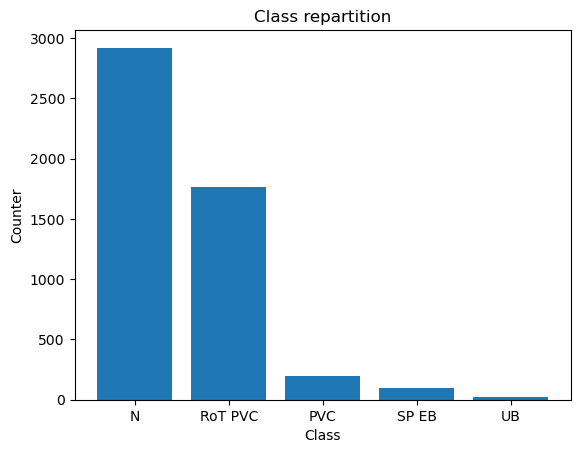

In [85]:
plt.bar(classes, list.values)
plt.title('Class repartition')
plt.xlabel('Class')
plt.ylabel('Counter')

Here, we can see that there is a significant imbalance between classes. In our case, this isn't a problem, as we'll be training our model on healthy ECGs only. What matters is to have enough healthy data, and enough pathological data, whatever the class.  

In [86]:
df['Normal'] = df.target_formated.apply(lambda x: 1 if x=='N' else 0)

In [87]:
dff = df.drop(['target', 'target_formated', 'Normal'], axis='columns')

In [22]:
def plot_serie(data, class_name, window=10):
    mean = data.mean(axis='index')
    std = data.std(axis='index')
    mean_smooth = mean.rolling(window=window, center=True).mean()
    std_smooth = std.rolling(window=window, center=True).mean()
    plt.plot(mean_smooth, label='Mean (smoothed)', color='blue')
    plt.fill_between(range(data.shape[1]),
                     mean_smooth - std,
                     mean_smooth + std,
                     color='blue', alpha=0.2, label='Std (smoothed)')

    plt.title('Mean representation of ' + class_name)
    plt.legend()
    plt.xticks(np.linspace(0, len(mean), 5))

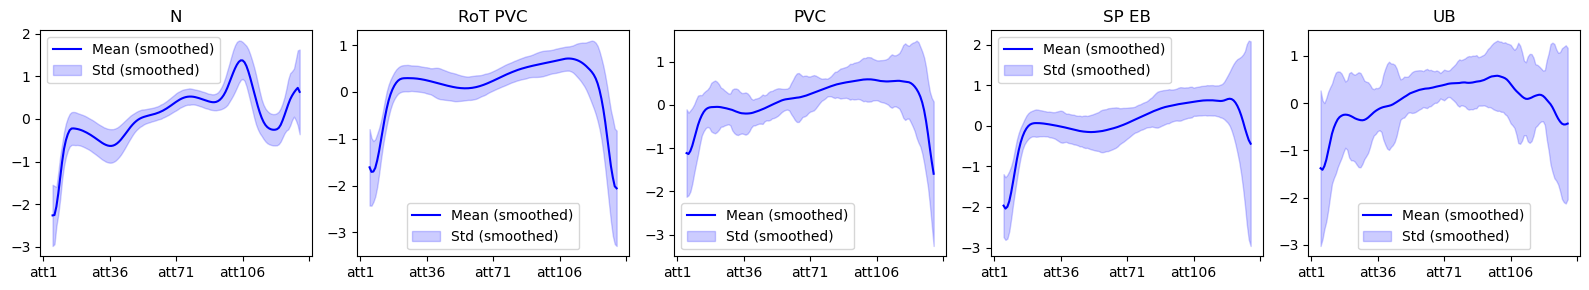

In [118]:
plt.figure(figsize=(16,3))
for i, class_name in enumerate(classes):
    df_tmp = df[df.target_formated == class_name].drop(['target', 'target_formated', 'Normal'], axis='columns')
    plt.subplot(1, len(classes), i + 1)
    plot_serie(df_tmp, class_name)
    plt.title(class_name)

plt.tight_layout()
plt.show()

We observe that only the normal beats have a typical pattern with specific variations. We will try to build a model that can take advantage of this feature. 

As said previously, the pathology categories won't be distinguished from one to another. Thus, later on, we'll separate the data into 'Normal' and 'Abnormal'.

In [24]:
df_normal = df[df.Normal==1].drop(['target', 'target_formated', 'Normal'], axis='columns')
df_abnormal = df[df.Normal==0].drop(['target', 'target_formated', 'Normal'], axis='columns')

# Creation of datasets

To get into the details of the model, we'll use an LSTM autoencoder. This model is often used in Deep Learning to detect anomalies in sequences.  
The model compresses complex sequences and then learns to reconstruct them, and if a sequence is abnormal, the reconstruction error will be high, indicating an anomaly. Thus, we will train our model on normal ECG, and classify other data according to the loss computed. Bad sequences are assumed to be poorly reconstructed, and therefore detectable in this way.

To achieve this, we'll be using a model implemented in Pytorch, hence the need to convert our data into torch.Tensors.

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train_df_tmp, test_df = train_test_split(df_normal, test_size=0.1, random_state=RANDOM_SEED)
train_df, val_df = train_test_split(train_df_tmp, test_size=0.1, random_state=RANDOM_SEED)

In [27]:
print(f'The train dataset contains {train_df.shape[0]} samples')
print(f'The test dataset contains {test_df.shape[0]} samples')
print(f'The validation dataset contains {val_df.shape[0]} samples')

The train dataset contains 2364 samples
The test dataset contains 292 samples
The validation dataset contains 263 samples


In [28]:
def create_dataset_from_df(df):
    sequences = df.values.tolist()
    dataset = [torch.tensor(seq).unsqueeze(1) for seq in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [29]:
train_dataset, seq_len, n_features = create_dataset_from_df(train_df)
test_dataset, seq_len, n_features = create_dataset_from_df(test_df)
val_dataset, seq_len, n_features = create_dataset_from_df(val_df)
abnormal_dataset, seq_len, n_features = create_dataset_from_df(df_abnormal)

# Model conception & training

In [31]:
class LSTMencoder(nn.Module):
    def __init__(self, seq_len, n_features, neurons_latent_layer=128, batch_size=1):
        super().__init__()
        self.hidden_layer_size = 2*neurons_latent_layer
        self.num_layers = 1
        self.seq_len = seq_len
        self.n_features = n_features
        self.neurons_latent_layer = neurons_latent_layer
        self.batch_size = batch_size

        self.lstm1 = nn.LSTM(
            input_size= self.n_features,
            hidden_size= self.hidden_layer_size,
            num_layers= self.num_layers,
            batch_first=True
        )
        self.lstm2 = nn.LSTM(
            input_size= self.hidden_layer_size,
            hidden_size= self.neurons_latent_layer,
            num_layers= self.num_layers,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((self.batch_size, self.seq_len, self.n_features))
        x, (h_n, c_n) = self.lstm1(x)
        x, (h_n, c_n) = self.lstm2(x)
        return h_n.reshape((self.batch_size, self.neurons_latent_layer))

class LSTMdecoder(nn.Module):
    def __init__(self, output_size, seq_len, n_features, neurons_latent_layer=128, batch_size=1):
        super().__init__()
        self.neurons_latent_layer = neurons_latent_layer
        self.hidden_layer_size = 2* neurons_latent_layer
        self.num_layers = 1
        self.output_size = output_size
        self.seq_len = seq_len
        self.n_features = n_features
        self.batch_size = batch_size

        self.latent = nn.LSTM(
            input_size = self.neurons_latent_layer,
            hidden_size = self.neurons_latent_layer,
            num_layers = self.num_layers,
            batch_first = True
        )
        self.lstm = nn.LSTM(
            input_size = self.neurons_latent_layer,
            hidden_size = self.hidden_layer_size,
            num_layers = self.num_layers,
            batch_first = True
        )
        self.dense = nn.Linear(self.hidden_layer_size, self.output_size)

    def forward(self, x):
        x = x.repeat(self.seq_len, 1)
        x = x.reshape((self.batch_size, self.seq_len, self.neurons_latent_layer))
        x, (h_n, c_n) = self.latent(x)
        x, (h_n, c_n) = self.lstm(x)
        x = self.dense(x)
        x = x.view(self.batch_size, self.seq_len, self.n_features)
        return x

class ADmodel(nn.Module):
    def __init__(self, seq_len, n_features, output_size=1, neurons_latent_layer=128, batch_size=1):
        super().__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.neurons_latent_layer = neurons_latent_layer
        self.batch_size = batch_size
        self.output_size = output_size
        self.encoder = LSTMencoder(seq_len, n_features, neurons_latent_layer, batch_size)
        self.decoder = LSTMdecoder(output_size, seq_len, n_features, neurons_latent_layer, batch_size)

    def forward(self, x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x

In [32]:
model = ADmodel(seq_len = seq_len, n_features = n_features)
model = model.to(device)

In [33]:
def train_model(model, train_dataset, val_dataset, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.L1Loss(reduction='sum')
    best_val_loss = float("inf")
    best_model = None

    mean_train_losses_per_epoch = []
    mean_val_losses_per_epoch = []
    for epoch in range(epochs):
        model = model.train()
        train_losses = []
        for sequence in train_dataset:
            sequence = sequence.to(device)
            optimizer.zero_grad()
            y_pred = model(sequence)
            y_pred = y_pred.view(sequence.size())
            loss = criterion(sequence, y_pred)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        model = model.eval()
        val_losses = []
        with torch.no_grad():
            for sequence_val in val_dataset:
                sequence_val = sequence_val.to(device)
                y_val = model(sequence_val)
                y_val = y_val.view(sequence_val.size())
                loss_val = criterion(sequence_val, y_val)
                val_losses.append(loss_val.item())

        mean_train_losses_per_epoch.append(np.mean(train_losses))
        mean_val_losses_per_epoch.append(np.mean(val_losses))

        if np.mean(val_losses) < best_val_loss:
            best_val_loss = np.mean(val_losses)
            best_model = model.state_dict()
            torch.save(best_model, 'model.pth')


        print(f'Epoch {epoch}/{epochs} : Train loss = {np.mean(train_losses)} /// Val loss = {np.mean(val_losses)}')

    return model, mean_train_losses_per_epoch, mean_val_losses_per_epoch

The model was trained in google Colab (A100 GPU), and saved as 'model.pth'. The loss function learning curves are taken from a google Colab screenshot taken after my training.

In [34]:
# model, train_losses, val_losses = train_model(model, train_dataset, val_dataset, 150)
# plt.plot(train_losses, label='Train loss')
# plt.plot(val_losses, label='Val loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.savefig('loss_curve.png')

(-0.5, 639.5, 479.5, -0.5)

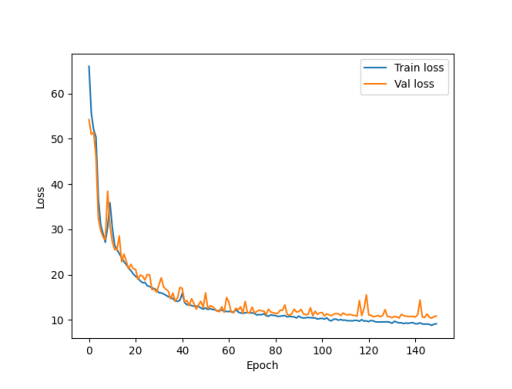

In [37]:
plt.imshow(plt.imread('loss_curve.png'))
plt.axis('off')

Here, the training do not suggest any overfitting since the validation curve is following the training one.

In [100]:
# from google.colab import files
# files.download('model.pth')
# files.download('loss_curve.png')

In [89]:
model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

# Results

All that remains is to write and operate the prediction function that will allow us to observe the model's results.

In [39]:
def predict(model, dataset):
  model = model.eval()
  criterion = nn.L1Loss(reduction='sum')
  losses = []
  predictions = []
  with torch.no_grad():
    for sequence in dataset:
      sequence = sequence.to(device)
      y_pred = model(sequence)
      y_pred = y_pred.view(sequence.size())
      predictions.append(y_pred)
      loss = criterion(sequence, y_pred)
      losses.append(loss.item())
  return predictions, losses

At this point, it's a good idea to check the theory behind our model: abnormal ECGs will be poorly reconstructed, and that's how they'll be detected. 

To do this, we reconstruct a normal sample, and one of each of the pathologies mentioned in the introduction.

In [95]:
np.random.seed(RANDOM_SEED)
normal_sample = test_dataset[np.random.randint(0,292)]
abnormal_classes = ['RoT PVC','PVC','SP EB','UB']

df_random_samples = pd.DataFrame()
for class_name in abnormal_classes:
    df_tmp = df[df.target_formated==class_name].sample(1)
    df_random_samples = pd.concat([df_random_samples, df_tmp], axis='index')

In [96]:
random_samples, seq_len, n_features = create_dataset_from_df(df_random_samples.drop(['target', 'target_formated', 'Normal'], axis='columns'))

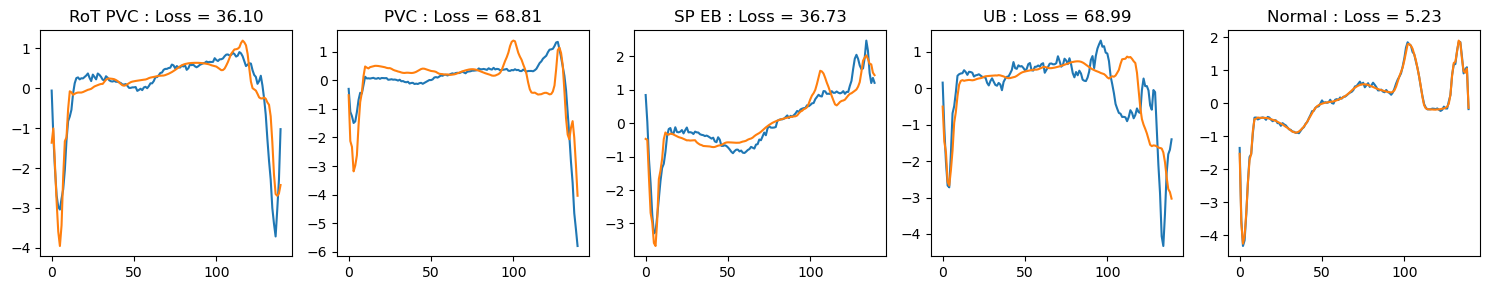

In [64]:
plt.figure(figsize=(15,3))
random_samples.append(normal_sample)
predictions, loss = predict(model, random_samples)

labels = abnormal_classes.copy()
labels.append('Normal')
for k, pred in enumerate(predictions):
    plt.subplot(1,5,k+1)
    plt.plot(random_samples[k])
    plt.plot(pred.detach().cpu().numpy())
    plt.title(f'{labels[k]} : Loss = {loss[k]:.2f}')
    plt.tight_layout()

As expected, the loss function is largely inferior for normal ECG reconstruction compared to the others.

Now, the prediction is evaluated on a test dataset consisting solely of normal ECGs, in order to define the threshold at which ECGs are considered abnormal.

In [97]:
predictions_normal, loss_normal = predict(model, test_dataset)
predictions_abnormal, loss_abnormal = predict(model, abnormal_dataset)

Text(13.819444444444445, 0.5, 'Density')

<Figure size 2000x1000 with 0 Axes>

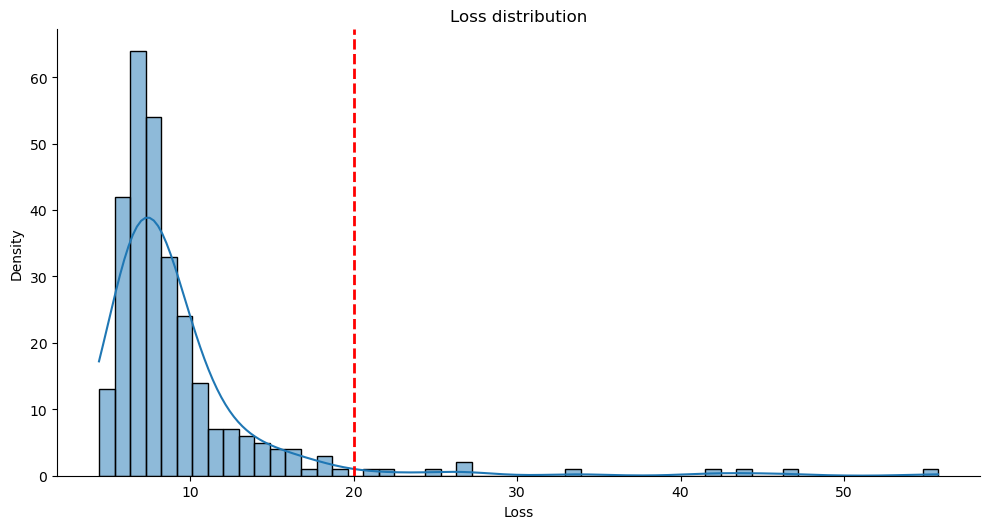

In [93]:
THRESHOLD = 20
plt.figure(figsize=(20,10))
sn.displot(loss_normal, kde=True, height=5, aspect=2)
plt.axvline(THRESHOLD, color='r', linestyle='dashed', linewidth=2)
plt.title('Loss distribution')
plt.xlabel('Loss')
plt.ylabel('Density')

This representation allows us to observe the distribution of calculated losses. We can see that the vast majority of normal ECGs have a loss of less than 20, so this is the value we'll choose as our threshold.

We can now calculate the detection of abnormal ECGs, based on this threshold, and plot the confusion matrix.

In [94]:
tn = np.sum(np.array(loss_normal) < THRESHOLD)
fn = np.sum(np.array(loss_normal) > THRESHOLD)
tp = np.sum(np.array(loss_abnormal) > THRESHOLD)
fp = np.sum(np.array(loss_abnormal) < THRESHOLD)

Text(0.5, 36.72222222222221, 'True')

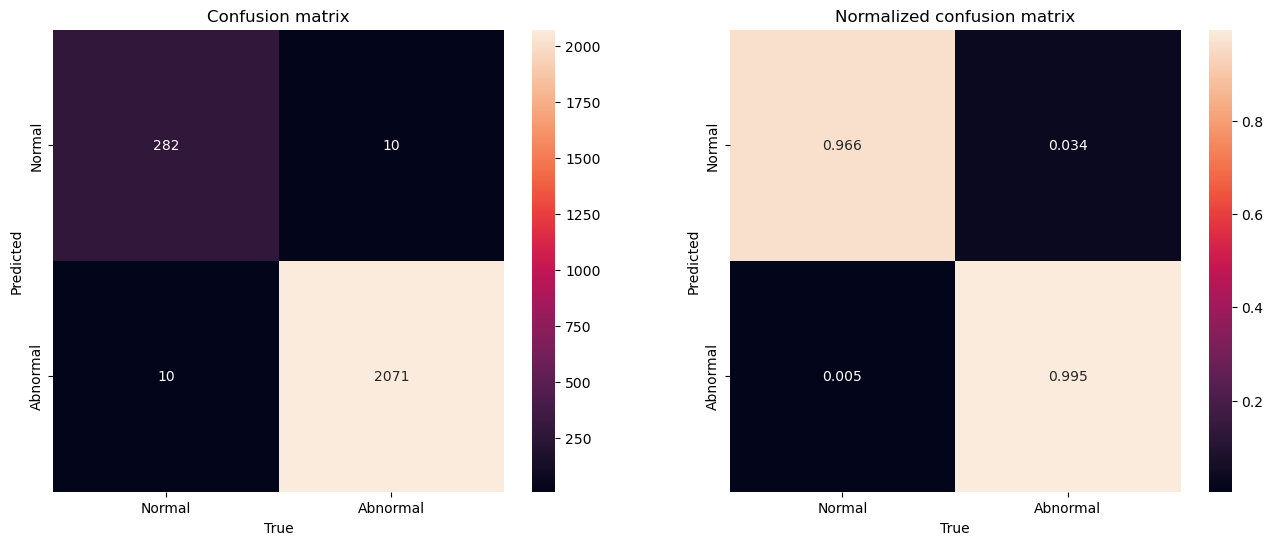

In [99]:
confusion_matrix = np.array([[tn, fp], [fn, tp]])
confusion_matrix_normalized = np.array([[tn, fp]/(tn+fp), [fn, tp]/(fn+tp)])
plt.figure(figsize=(16,6))
plt.subplot(1,2,1),
sn.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion matrix')
plt.ylabel('Predicted')
plt.xlabel('True')

plt.subplot(1,2,2),
sn.heatmap(confusion_matrix_normalized, annot=True, fmt='.3f', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Normalized confusion matrix')
plt.ylabel('Predicted')
plt.xlabel('True')

The model's performance seems excellent: the vast majority of abnormal ECGs are detected as such.  
In this crucial case of ECG anomaly detection, it might be wise to reduce the threshold even further: this would result in an increase in false positives (normals considered as abnormal), but would reduce the number of false negatives (abnormals detected as normal).